In [1]:
import time
import copy
import os
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

## Part 1 -- Data

In [2]:
dir_data = '/home/hhg/Research/emu_Nx2pt/data/'
filename = dir_data+'pco_train_1000000.pkl'
startID, endID = 0, 10000

with open(filename, 'rb') as handle:
    pco_samples = pickle.load(handle)

df_pco = pd.DataFrame(pco_samples).iloc[startID:endID]
df_pco.head()

,Omega_m,sigma_8,n_s,w0,wa,Omega_b,h0,A_ia,eta_ia,gas_0,gas_1,gas_2,gas_3,gas_7,gas_8,gas_9,gas_10
0,0.297210,0.844420,0.946421,-0.899775,0.920549,0.042484,0.709375,0.431978,-0.498661,1.169694,0.424419,13.401518,1.316665,6.522245,0.792762,-0.075719,-0.168358
1,0.299879,0.831514,0.973854,-0.826622,0.814782,0.039073,0.613814,0.406599,0.267230,1.177757,0.326897,13.799217,1.320319,6.433461,0.675128,0.117878,0.083608
2,0.312924,0.832181,0.980610,-0.797240,0.904636,0.044502,0.684378,0.527645,0.315681,1.167045,0.955779,14.335774,1.288770,6.633679,0.832012,-0.153872,-0.044284
3,0.301810,0.850645,0.955667,-1.071412,-0.417694,0.056777,0.715881,0.447567,0.234797,1.169956,0.943896,14.356193,0.997335,6.577022,0.670646,-0.117672,0.035089
4,0.328350,0.844306,0.999254,-0.774267,-0.586787,0.057157,0.659152,0.512589,-0.189984,1.162550,0.618421,14.138517,0.849018,6.452518,0.677463,-0.033036,-0.062468


In [3]:
Nsamples = len(df_pco['Omega_m'])
sampleID = list(range(Nsamples))

trainID, validID = train_test_split(sampleID, train_size=0.7, random_state=0)

In [4]:
class datavDataset(Dataset):
    
    def __init__(self, IDs, df_pco, dir_datav, transform=None):
        self.IDs = IDs
        self.dir_datav = dir_datav
        self.df_pco = df_pco
        
    def __getitem__(self, index):
        pcoID = self.IDs[index]
        dataT = torch.load( os.path.join(self.dir_datav, 'dataT_'+str(pcoID)+'.pt') )
        pco = torch.from_numpy(df_pco.loc[[pcoID]].values[0]).float()
        return pco, dataT
    
    def __len__(self):
        return len(self.IDs)

In [5]:
dir_datav = '/home/hhg/Research/emu_Nx2pt/data/train_1M/'

dataset = {}
dataset['train'] = datavDataset(trainID, df_pco, dir_datav)
dataset['valid'] = datavDataset(validID, df_pco, dir_datav)

In [6]:
batch_size = 64

dataloader = {}
dataloader['train'] = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True)
dataloader['valid'] = DataLoader(dataset['valid'], batch_size=batch_size, shuffle=True)

In [7]:
validSamples = iter(dataloader['valid'])
pco, datav = validSamples.next()
Nout = len(datav[0])

## Part 2 -- Model

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# Device configuration 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Npco = pco.shape[1]
Nout = len(datav[0])
Nhidden = 64
Nblocks = 2

class MLP(nn.Module):
    
    def __init__(self, Npco, Nout, Nblocks, Nhidden):
        super().__init__()
        self.Nblocks = Nblocks

        self.in_layer   = nn.Sequential(nn.Linear(Npco, Nhidden), nn.ReLU())

        self.mid_layers = nn.ModuleDict()
        for i in range(Nblocks):
            self.mid_layers[f"block_{i}"] = nn.Sequential(nn.Linear(Nhidden, Nhidden), nn.ReLU())

        self.out_layer  = nn.Linear(Nhidden, Nout)
        
    
    def forward(self, x):
        x = self.in_layer(x)
        
        for i in range(self.Nblocks):
            x = self.mid_layers[f"block_{i}"](x)
        
        x = self.out_layer(x)
        
        return x

In [9]:
class ChiSquare(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, predicted, actual):
        chi2 = ((predicted - actual) ** 2).sum() # mse = ((predicted - actual) ** 2).mean()
        return chi2

In [10]:
# ------ Hyper-parameters ------ 
num_epochs = 20
batch_size = batch_size
learning_rate = 0.1
step_size = 10
gamma = 0.1
early_stop_threshold = 10

########################

model = MLP(Npco, Nout, Nblocks, Nhidden).to(device)

#criterion = nn.MSELoss()
criterion = ChiSquare()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

## Part 3 -- Training & Validation

In [11]:
current_epoch = 0
best_epoch    = 0
best_model_wts = copy.deepcopy(model.state_dict())
min_valid_loss = np.inf

save_key = ['train_loss', 'valid_loss', 'epoch_train_loss', 'epoch_valid_loss', 'lr']
trainInfo = {key:[] for key in save_key}

for epoch in range(num_epochs):
    current_epoch = epoch
    
    # ---------------------------------
    # ------ START TRAIN 1 EPOCH ------
    # ---------------------------------
    
    since = time.time()
    
    print(f'Epoch {current_epoch+1}/{num_epochs}')
    for phase in ['train', 'valid']:
        
        if phase == 'train': 
            model.train()
        else:
            model.eval()
        
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(dataloader[phase]):
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            
            trainInfo[f'{phase}_loss'].append( loss.item()/inputs.size(0) )
            
            running_loss += loss.item()
        
        # ------ End training the epoch in a train or valid phase ------
        
        epoch_loss = running_loss / len(dataset[phase])
        trainInfo[f'epoch_{phase}_loss'].append(epoch_loss)
        
        print(f'\t{phase} avg_chi2: {epoch_loss:.2f}', end='')
        
        
        if phase == 'train':
            scheduler.step()

        if phase == 'valid':
            if epoch_loss < min_valid_loss: # -> deep copy the model
                best_epoch = current_epoch
                min_valid_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
              
    # ------ End training the ephch in both train & valid phases ------
    trainInfo['lr'].append(scheduler.get_last_lr()[0]) # save lr / epoch
    time_cost = time.time() - since
    print(f'\tTime: {time_cost//60:.0f}m {time_cost%60:.0f}s')    
    
    # -------------------------------
    # ------ END TRAIN 1 EPOCH ------
    # -------------------------------
    
    if current_epoch - best_epoch >= early_stop_threshold:
        print(f'Early stopping... (Model did not imporve after {early_stop_threshold} epochs)')
        break

print(f'\nMinimum (epoch-averaged) validation loss reached at epoch {best_epoch+1}.')

Epoch 1/20
	train avg_chi2: 210879.36	valid avg_chi2: 69450.86	Time: 0m 3s
Epoch 2/20
	train avg_chi2: 70265.75	valid avg_chi2: 69090.42	Time: 0m 3s
Epoch 3/20
	train avg_chi2: 63939.05	valid avg_chi2: 57573.47	Time: 0m 3s
Epoch 4/20
	train avg_chi2: 55217.04	valid avg_chi2: 81877.73	Time: 0m 3s
Epoch 5/20
	train avg_chi2: 56355.15	valid avg_chi2: 49320.36	Time: 0m 3s
Epoch 6/20
	train avg_chi2: 51769.85	valid avg_chi2: 48877.96	Time: 0m 3s
Epoch 7/20
	train avg_chi2: 50110.51	valid avg_chi2: 47884.88	Time: 0m 3s
Epoch 8/20
	train avg_chi2: 49503.66	valid avg_chi2: 47168.80	Time: 0m 3s
Epoch 9/20
	train avg_chi2: 48668.57	valid avg_chi2: 51229.68	Time: 0m 3s
Epoch 10/20
	train avg_chi2: 48031.97	valid avg_chi2: 47516.02	Time: 0m 3s
Epoch 11/20
	train avg_chi2: 45544.64	valid avg_chi2: 46452.81	Time: 0m 3s
Epoch 12/20
	train avg_chi2: 45300.90	valid avg_chi2: 45689.16	Time: 0m 3s
Epoch 13/20
	train avg_chi2: 45349.57	valid avg_chi2: 45927.30	Time: 0m 3s
Epoch 14/20
	train avg_chi2: 4528

## Plots -- Training Process

In [12]:
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rc('font', size=16)

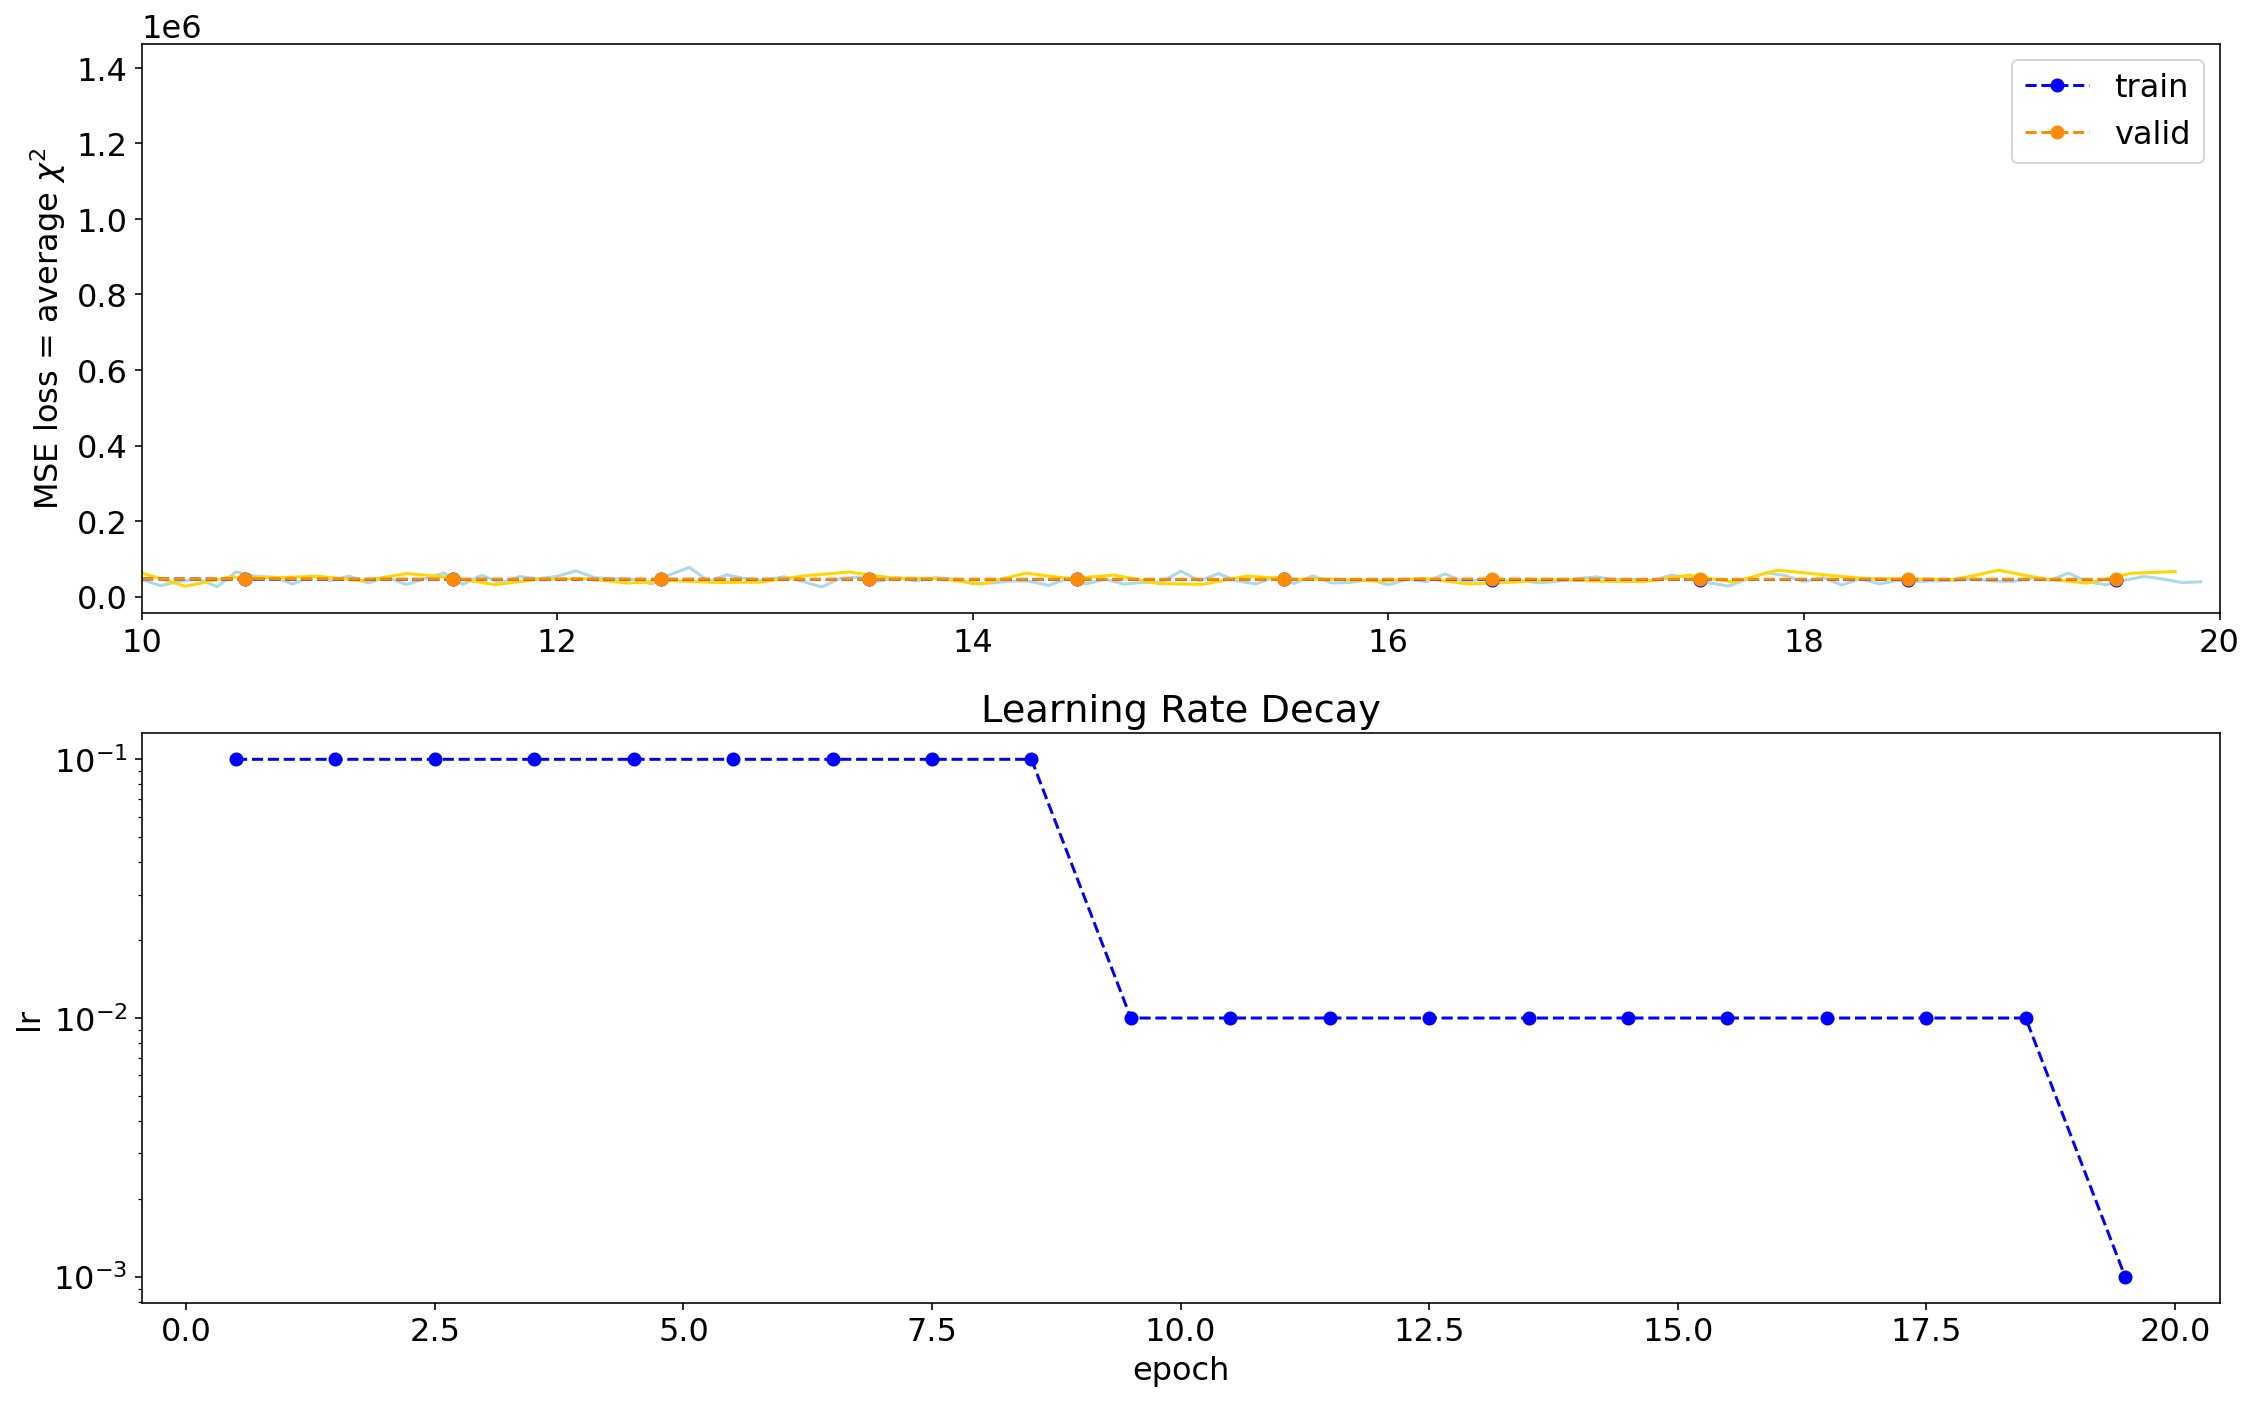

In [13]:
iter_tick = {}
for phase in ['train', 'valid']:
    iter_tick[phase] = np.array(range(len(trainInfo[f'{phase}_loss'])))/len(dataloader[phase])

epoch_tick = np.array(range(len(trainInfo['epoch_train_loss'])))+0.5

# --------------------------

plt.figure(figsize=(16,10))

plt.subplot(211)

n = 10
plt.plot(iter_tick['train'][::n], trainInfo['train_loss'][::n], color='lightblue')
plt.plot(iter_tick['valid'][::n], trainInfo['valid_loss'][::n], color='gold')

plt.plot(epoch_tick, trainInfo['epoch_train_loss'], 'o--', label='train', color='b')
plt.plot(epoch_tick, trainInfo['epoch_valid_loss'], 'o--', label='valid', color='darkorange')

plt.ylabel('MSE loss = average $\chi^2$')

plt.legend()

plt.xlim([10,20])
#plt.ylim([0,10000])


plt.subplot(212)
plt.plot(epoch_tick, trainInfo['lr'], 'o--', label='train', color='b' )
plt.title('Learning Rate Decay')
plt.ylabel('lr')
plt.yscale('log')
plt.xlabel('epoch')


plt.tight_layout()

## Plots -- Visualize the best-trained emulator

In [14]:
dvID = 30

validSamples = iter(dataloader['valid'])
with torch.no_grad():
    pco, datav = validSamples.next()
    pco = pco.to(device)
    
    datavT = datav.to(device)
    predictT = model(pco)
    
predict = predictT.to('cpu').numpy()
datav = datavT.to('cpu').numpy()

criterion_chi2 = ChiSquare()
chi2 = criterion_chi2(predictT[dvID], datavT[dvID]).to('cpu').numpy()

Text(0, 0.5, 'fractional difference')

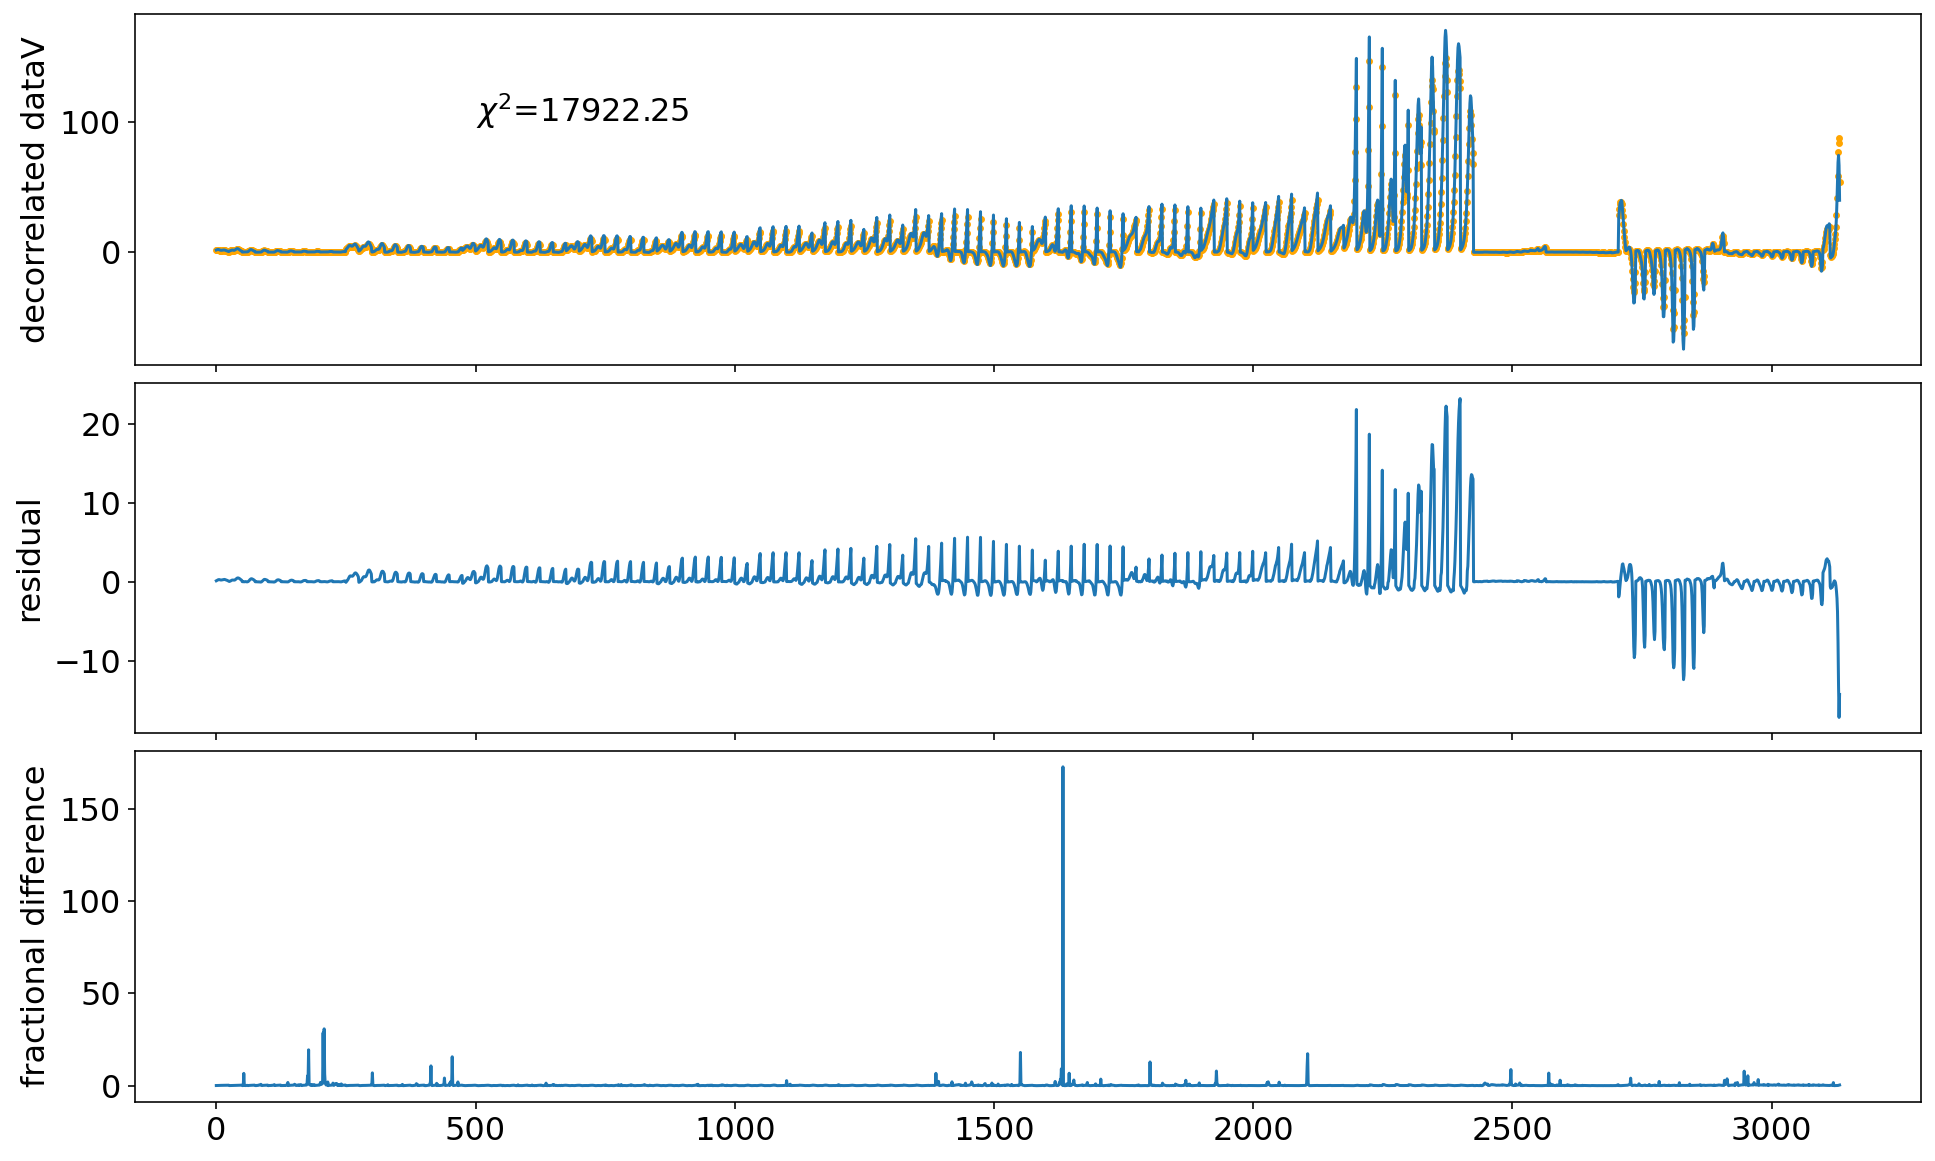

In [15]:
plt.figure(figsize=(16,10))
plt.subplots_adjust(hspace=0.05)


plt.subplot(311)
plt.plot(range(0,len(datav[dvID])), datav[dvID])
plt.scatter(range(0,len(datav[dvID])), predict[dvID], s=6, color='orange')
plt.ylabel('decorrelated dataV')
plt.xticks(range(0,len(datav[dvID]), 500),[])
plt.text(500, 100, f"$\chi^2$={chi2:.2f}")

plt.subplot(312)
plt.plot( range(0,len(datav[dvID])), datav[dvID]-predict[dvID])
plt.ylabel('residual')
plt.xticks(range(0,len(datav[dvID]), 500),[])

plt.subplot(313)
plt.plot( range(0,len(datav[dvID])), abs(datav[dvID]-predict[dvID])/abs(datav[dvID]) )
plt.ylabel('fractional difference')

## Check in detail nn.MSELoss( ) v.s. ChiSquare( ) I defined. 

In [16]:
dvID = 30

validSamples = iter(dataloader['valid'])
with torch.no_grad():
    pco, datav = validSamples.next()
    pco = pco.to(device)
    
    datavT = datav.to(device)
    predictT = model(pco)


criterion_chi2 = ChiSquare()
criterion_mse  = nn.MSELoss()
    
loss_chi2 = criterion_chi2(predictT, datavT)
loss_mse  = criterion_mse(predictT, datavT)

In [17]:
predict = predictT.to('cpu').numpy()
datav = datavT.to('cpu').numpy()

chi2_arr = np.zeros(64)
mse_arr = np.zeros(64)
for i in range(64):
    diff = datav[i]-predict[i]
    chi2 = np.sum(diff**2)
    mse  = np.mean(diff**2)
    chi2_arr[i] = chi2
    mse_arr[i] = mse

In [18]:
loss_chi2, chi2_arr.sum()

(tensor(2202355.5000, device='cuda:0'), 2202355.480102539)

In [19]:
loss_mse, mse_arr.mean()

(tensor(10.9872, device='cuda:0'), 10.98716615140438)

In [20]:
criterion_chi2(predictT[30], datavT[30])

tensor(17322.3281, device='cuda:0')

In [21]:
chi2_arr[30]

17322.328125

## Back Ups

In [22]:
def train_one_epoch():
    since = time.time()
    
    print(f'Epoch {current_epoch+1}/{num_epochs}')
    for phase in ['train', 'valid']:
        
        if phase == 'train': 
            model = model.train()
        else:
            model = model.eval()
        
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(dataloader[phase]):
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            
            trainInfo[f'{phase}_loss'].append( loss.item() )
            
            running_loss += loss.item() * inputs.size(0)
        
        # ------ End training the epoch in a train or valid phase ------
        
        epoch_loss = running_loss / len(dataset[phase])
        trainInfo[f'epoch_{phase}_loss'].append(epoch_loss)
        
        print(f'\t{phase} Loss: {epoch_loss:.4f}', end='')
        
        
        if phase == 'train':
            scheduler.step()

        if phase == 'valid':
            if epoch_loss < min_valid_loss: # -> deep copy the model
                print('valid improvement', epoch_loss, min_valid_loss)
                best_epoch = current_epoch
                min_valid_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
              
    # ------ End training the ephch in both train & valid phases ------
    trainInfo['lr'].append(scheduler.get_last_lr()[0]) # save lr / epoch
    time_cost = time.time() - since
    print(f'\tTime: {time_cost//60:.0f}m {time_cost%60:.0f}s')